#### Import Dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [3]:
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D, RepeatVector
from keras.layers.advanced_activations import *
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.recurrent import LSTM
from keras.layers import Merge, Input, concatenate, GaussianNoise
from keras.layers import LeakyReLU

Using TensorFlow backend.


### Load the Training Data

In [4]:
inputData = pd.read_csv('trainData_set1.csv')

#### Replace Upcylce and Downcycle to Up and Down in the Indicative Tick Direction Column

In [5]:
inputData.TICKDIR.describe()

count     52396
unique        5
top        FLAT
freq      47029
Name: TICKDIR, dtype: object

In [6]:
subset = inputData.groupby(by='TICKDIR')['TIME'].count()
subset

TICKDIR
DOWN          1685
DOWNCYCLE     1163
FLAT         47029
UP            1665
UPCYCLE        854
Name: TIME, dtype: int64

In [7]:
inputData['TICKDIR'] = inputData.TICKDIR.str.replace('UPCYCLE', 'UP')
inputData['TICKDIR'] = inputData.TICKDIR.str.replace('DOWNCYCLE', 'DOWN')

In [8]:
subset = inputData.groupby(by='TICKDIR')['TIME'].count()
subset

TICKDIR
DOWN     2848
FLAT    47029
UP       2519
Name: TIME, dtype: int64

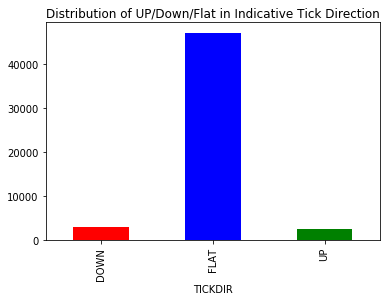

In [9]:
subset.plot(kind='bar', title='Distribution of UP/Down/Flat in Indicative Tick Direction',
           color=['red','blue','green']);

#### Extract a single feature - bid ask imbalance

In [10]:
# extracting a single feature
X = inputData.BIDASKIMBALANCE

#### Reshaping X as it has only one feature

In [11]:
X = np.array(X).reshape(-1,1)

In [12]:
X.shape

(52396, 1)

### Multi Classification 

#### Converting the Indicative Tick Direction to numerical format

In [21]:
y = inputData.TICKDIR.replace('UP', 1)
y = y.replace('FLAT', 0)
y = y.replace('DOWN', -1)

In [22]:
y.shape

(52396,)

In [23]:
y = pd.get_dummies(y)

In [24]:
y.shape

(52396, 3)

In [25]:
y = np.array(y)

In [18]:
#y = np.array(y).reshape(-1,1)

#### Reshaping X and Y for ingesting into the model

In [26]:
print("The shape of X is: ",X.shape)
print("The shape of y is: ",y.shape)

The shape of X is:  (52396, 1, 1)
The shape of y is:  (52396, 3)


In [27]:
X = X.reshape(X.shape[0],1, X.shape[1])
y = y.reshape(y.shape[0],1, y.shape[1])
print("The shape of x is: ",X.shape)
print("The shape of y is: ",y.shape)

The shape of x is:  (52396, 1, 1)
The shape of y is:  (52396, 1, 3)


#### Train test split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0)

#### Define model

In [29]:
# Define Model
# Sequential() creates the foundation of the layers.
model = Sequential()
# 'Dense' is the basic form of a neural network layer
# Input Layer of state size(4) and Hidden Layer with 16 nodes
model.add(Dense(16, input_shape= (1,1), activation='sigmoid'))
# Hidden layer with 24 nodes
model.add(Dense(8, activation='relu'))
# Hidden layer with 24 nodes
model.add(Dense(24))
#Adding advanced Activation Layer
model.add(LeakyReLU(alpha=0.1))
# Hidden layer with 24 nodes
model.add(Dense(8, activation='tanh'))
# Output Layer with # of actions: 3 nodes (sell,hold,buy) # Single Node - Absolute Price
model.add(Dense(3, activation='sigmoid'))
# Create the model based on the information above
model.compile(loss='binary_crossentropy', metrics =['accuracy'],optimizer=Adam(lr=0.001))

#### Train model

In [30]:
history = model.fit(X_train, y_train, epochs=10, verbose=1, validation_split = 0.25)

Train on 35367 samples, validate on 11789 samples
Epoch 1/10
35367/35367 [==============================] - 2s 64us/step - loss: 0.2689 - acc: 0.9152 - val_loss: 0.2196 - val_acc: 0.9323
Epoch 2/10
35367/35367 [==============================] - 2s 52us/step - loss: 0.2012 - acc: 0.9315 - val_loss: 0.1939 - val_acc: 0.9323
Epoch 3/10
35367/35367 [==============================] - 2s 54us/step - loss: 0.1914 - acc: 0.9315 - val_loss: 0.1887 - val_acc: 0.9323
Epoch 4/10
35367/35367 [==============================] - 2s 56us/step - loss: 0.1900 - acc: 0.9318 - val_loss: 0.1875 - val_acc: 0.9323
Epoch 5/10
35367/35367 [==============================] - 2s 57us/step - loss: 0.1890 - acc: 0.9327 - val_loss: 0.1874 - val_acc: 0.9355
Epoch 6/10
35367/35367 [==============================] - 2s 56us/step - loss: 0.1887 - acc: 0.9329 - val_loss: 0.1871 - val_acc: 0.9366
Epoch 7/10
35367/35367 [==============================] - 2s 54us/step - loss: 0.1885 - acc: 0.9337 - val_loss: 0.1910 - val_acc

#### Plot Loss and Accuracy 

In [31]:
from matplotlib import pyplot

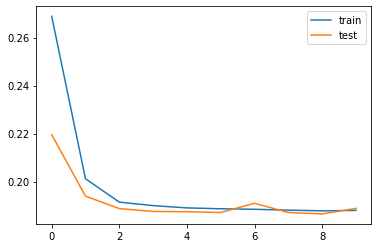

In [32]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

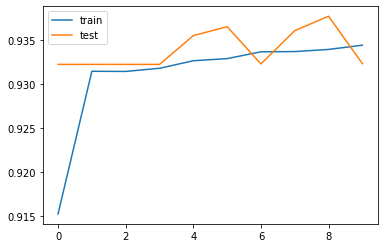

In [33]:
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()

#### Make a prediction

In [34]:
y_score = model.predict(X_test)

In [35]:
y_score.shape

(5240, 1, 3)

In [36]:
y_score[:10]

array([[[0.02410336, 0.96656656, 0.00669661]],

       [[0.00970144, 0.9290989 , 0.06260711]],

       [[0.03163566, 0.96022666, 0.0052546 ]],

       [[0.00938718, 0.9155529 , 0.07719107]],

       [[0.01416019, 0.9640415 , 0.01696555]],

       [[0.00836293, 0.7062687 , 0.29246092]],

       [[0.30697492, 0.7006555 , 0.00290416]],

       [[0.02198561, 0.9680705 , 0.00737246]],

       [[0.01263712, 0.9581571 , 0.02401968]],

       [[0.00940367, 0.9164821 , 0.07622045]]], dtype=float32)

#### Plot the distribution of the prediction

In [37]:
y_score = y_score.reshape(y_score.shape[0],3)


In [38]:
y_score.shape

(5240, 3)

In [39]:
y_score[:,0]

array([0.02410336, 0.00970144, 0.03163566, ..., 0.00992785, 0.01587546,
       0.01116729], dtype=float32)

In [54]:
localPredict = []

for i,j,k in zip(y_score[:,0], y_score[:,1], y_score[:,2]):
    
    if i > 0.3:
        predict = -1
        localPredict.append(predict)
    
    elif k > 0.3:
        predict = 1
        localPredict.append(predict)
        
    else:
        predict = 0
        localPredict.append(predict)

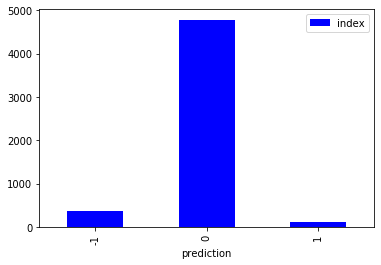

In [55]:
localPrediction = pd.DataFrame({'prediction': localPredict})
localPrediction1 = localPrediction.reset_index()
summary3 = localPrediction1.groupby(by='prediction').count()
summary3.plot(kind='bar', color='blue');

#### Confusion Matrix

In [56]:
y_pred = np.array(localPredict)

In [57]:
y_pred = y_pred.reshape(y_pred.shape[0],1)

In [58]:
y_pred.shape

(5240, 1)

In [59]:
y_test.shape

(5240, 3)

In [60]:
y_test = y_test.reshape(y_test.shape[0],3)

In [61]:
y_test.shape

(5240, 3)

In [62]:
yDF = pd.DataFrame(y_test)

In [63]:
yDF1 = yDF.idxmax(axis=1)

In [64]:
yDF2 = yDF1.replace(0,-1)
yDF3 = yDF2.replace(1,0)
yDF4 = yDF3.replace(2,1)

In [65]:
y_test2 = np.array(yDF4).reshape(yDF4.shape[0],1)

In [66]:
y_test2.shape

(5240, 1)

In [67]:
confusion_matrix(y_test2, y_pred)

array([[ 130,  150,    1],
       [ 224, 4450,   32],
       [   0,  184,   69]])

#### Accuracy Score

In [68]:
accuracy_score(y_test2, y_pred)

0.8872137404580153

#### Classification Report

#### Precision:
- The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. 
- The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

- The best value is 1 and the worst value is 0.

#### Recall:
- The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. 
- The recall is intuitively the ability of the classifier to find all the positive samples.

- The best value is 1 and the worst value is 0.

#### F-1 Score:
- The F1 score can be interpreted as a weighted average of the precision and recall.
- An F1 score reaches its best value at 1 and worst score at 0.
- The relative contribution of precision and recall to the F1 score are equal.
- F1 = 2 x (precision x recall) / (precision + recall)

In [69]:
print(classification_report(y_test2, y_pred, labels=[-1,0,1]))

              precision    recall  f1-score   support

          -1       0.37      0.46      0.41       281
           0       0.93      0.95      0.94      4706
           1       0.68      0.27      0.39       253

    accuracy                           0.89      5240
   macro avg       0.66      0.56      0.58      5240
weighted avg       0.89      0.89      0.88      5240

